In [4]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jre_utils.datapath import model_ready_data_paths

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, r2_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [5]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric = metrics["median"]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
upcoming_metric_pct_chg = "upcoming_" + metric_pct_chg
normalized_upcoming_metric_pct_chg = "normalized_" + "upcoming_" + metric_pct_chg

In [13]:
dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"xgb_{dataset_key}"]

df = pd.read_csv(model_ready_data_path)
df[normalized_upcoming_metric_pct_chg] = df.groupby("year")[
    upcoming_metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

In [27]:
# y_columns = [upcoming_metric_pct_chg]
y_columns = [normalized_upcoming_metric_pct_chg]

X_categorical_columns = ["area_code", "area"]

X_basic_columns = [
    "year",
    "population",
    "count",
    "taxable_income_per_taxpayer",
    "taxable_income_per_taxpayer_growth",
]

X_engineering_columns = [
    "net_migration_ratio",
    "taxable_income_growth",
    "new_dwellings_ratio",
    metric_pct_chg,
]

X_engineered_columns = [
    "net_migration_ratio_ma3",
    "net_migration_ratio_cumu3",
    "net_migration_ratio_lag1",
    "taxable_income_growth_ma3",
    "taxable_income_growth_cumu3",
    "taxable_income_growth_lag1",
    "new_dwellings_ratio_ma3",
    "new_dwellings_ratio_cumu3",
    "new_dwellings_ratio_lag1",
    "unit_price_median_pct_chg_ma3",
    "unit_price_median_pct_chg_cumu3",
    "unit_price_median_pct_chg_lag1",
]

X_columns = (
    X_categorical_columns
    + X_basic_columns
    + X_engineering_columns
    + X_engineered_columns
)

In [28]:
divide_year = 2020 # test_years = [2021]
train_df = df[df["year"] <= divide_year]
test_df = df[df["year"] > divide_year]

drop_columns = ["year", "area_code", "area"]
X_train_df, X_test_df = train_df[X_columns].drop(columns=drop_columns), test_df[X_columns].drop(columns=drop_columns)
y_train_df, y_test_df = train_df[y_columns], test_df[y_columns]

In [29]:
X_train_df.shape, y_train_df.shape

((18421, 20), (18421, 1))

<Axes: ylabel='Frequency'>

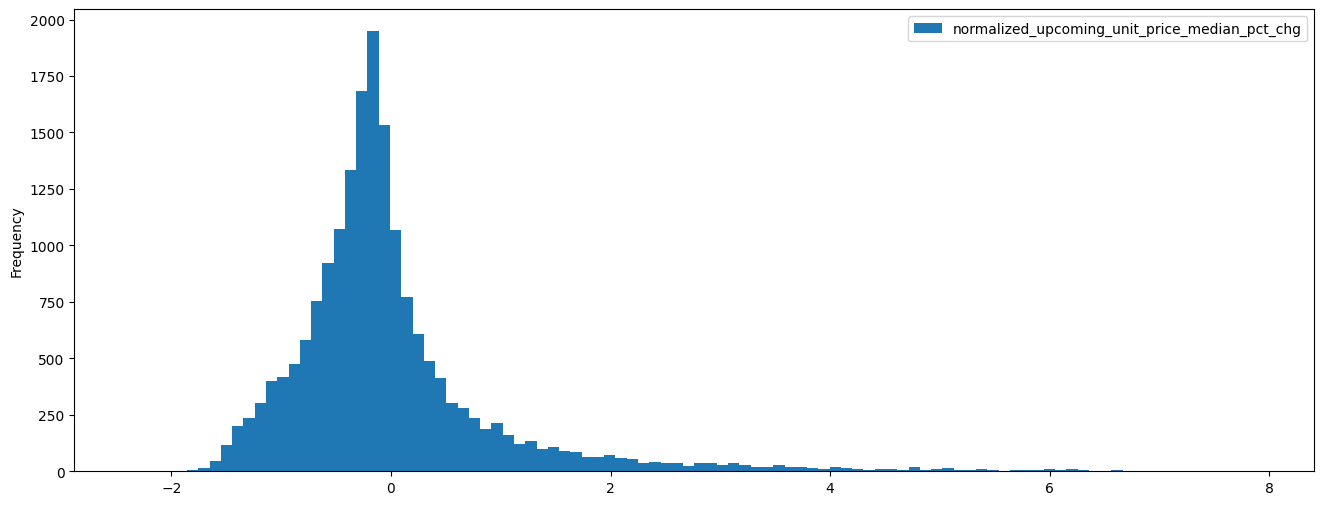

In [30]:
y_train_df.plot.hist(bins=100, figsize=(16, 6))

In [37]:
# xgb_regressor = XGBRegressor(tree_method="gpu_hist", gpu_id=0, predictor="gpu_predictor")
xgb_regressor = XGBRegressor(
    tree_method="hist", early_stopping_rounds=4, enable_categorical=True
)
xgb_regressor.fit(X_train_df, y_train_df, eval_set=[(X_test_df, y_test_df)])

y_train_pred = xgb_regressor.predict(X_train_df)
y_test_pred = xgb_regressor.predict(X_test_df)

print()
print(f"Train RMSE: {mean_squared_error(y_train_df, y_train_pred, squared=False):.4f}")
print(f"Test RMSE: {mean_squared_error(y_test_df, y_test_pred, squared=False):.4f}")

print(f"Train R2: {r2_score(y_train_df.values.squeeze(), y_train_pred):.4f}")
print(f"Test R2: {r2_score(y_test_df.values.squeeze(), y_test_pred):.4f}")

[0]	validation_0-rmse:0.94448
[1]	validation_0-rmse:0.91198
[2]	validation_0-rmse:0.89415
[3]	validation_0-rmse:0.88505


[4]	validation_0-rmse:0.87802
[5]	validation_0-rmse:0.87659
[6]	validation_0-rmse:0.87021
[7]	validation_0-rmse:0.86808
[8]	validation_0-rmse:0.86820
[9]	validation_0-rmse:0.86904
[10]	validation_0-rmse:0.86927

Train RMSE: 0.7860
Test RMSE: 0.8681
Train R2: 0.3816
Test R2: 0.2459


In [38]:
mean_squared_error(y_train_df, y_train_pred)

0.6178709035794548

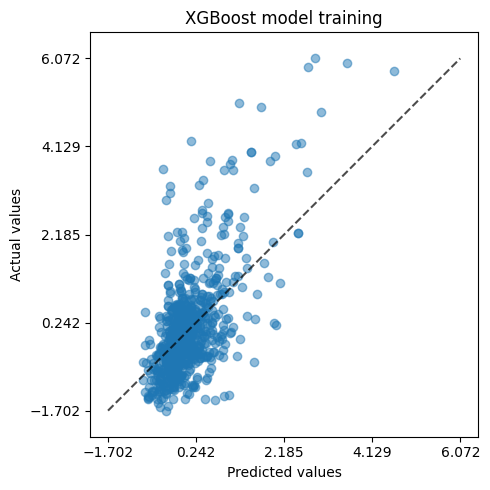

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_train_df.values.squeeze(),
    y_train_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model training")
plt.tight_layout()

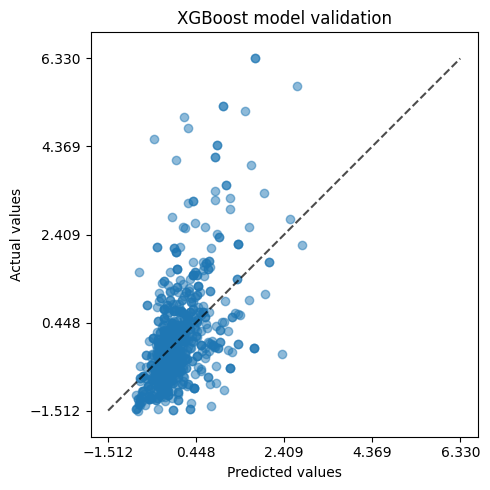

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test_df.values.squeeze(),
    y_test_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model validation")
plt.tight_layout()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

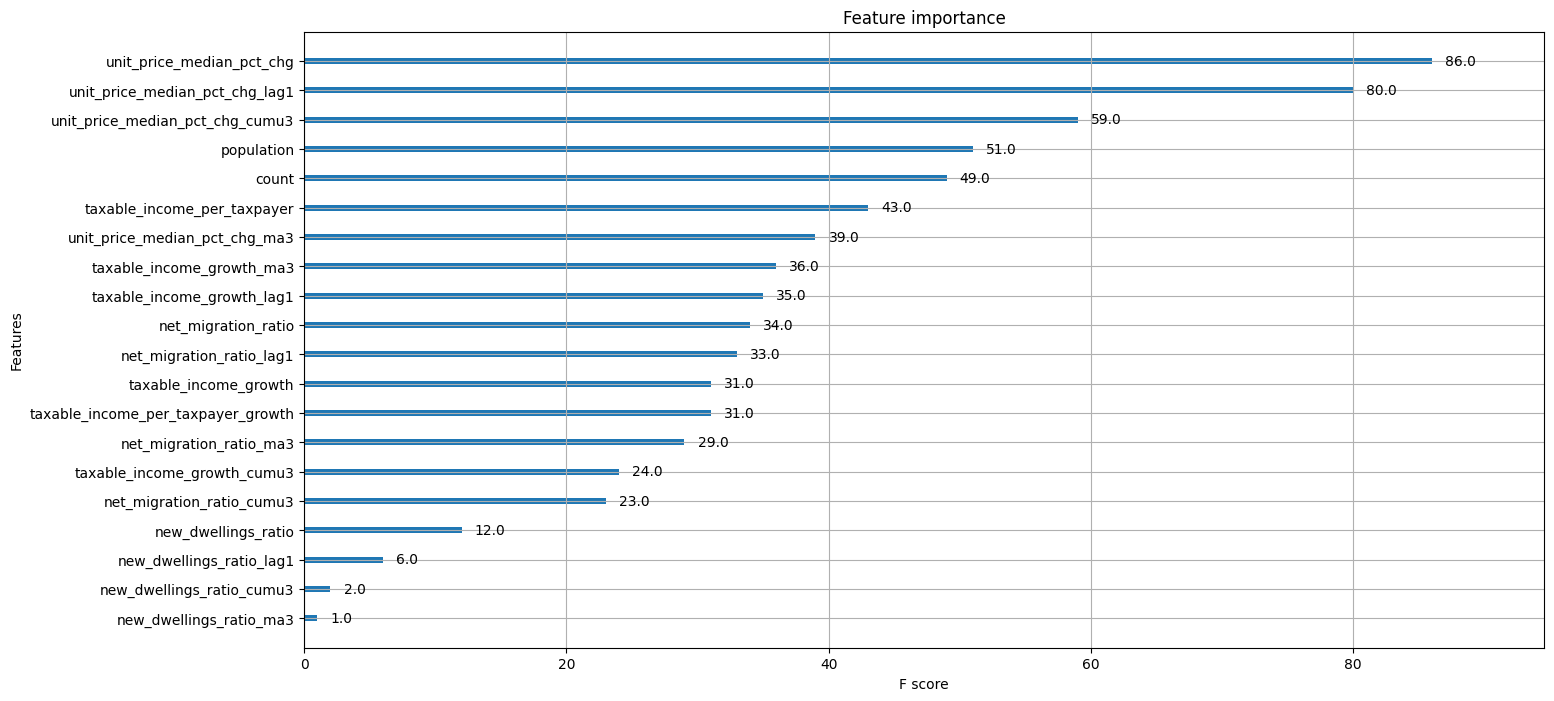

In [41]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_regressor)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

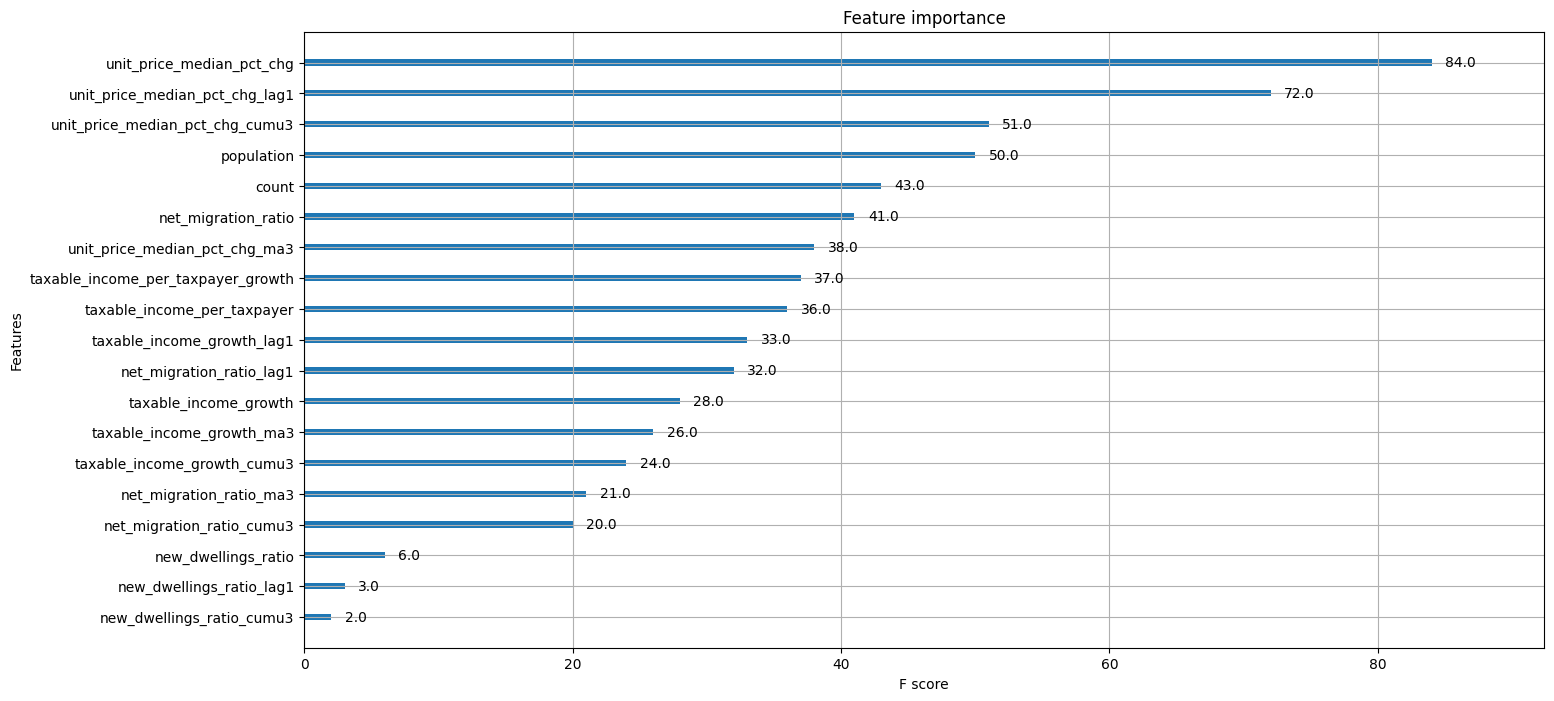

In [19]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_regressor)